# FastAI Séance 5

In [6]:
from fastai.vision.all import *

## Rappel structure DataBlock and dataloaders

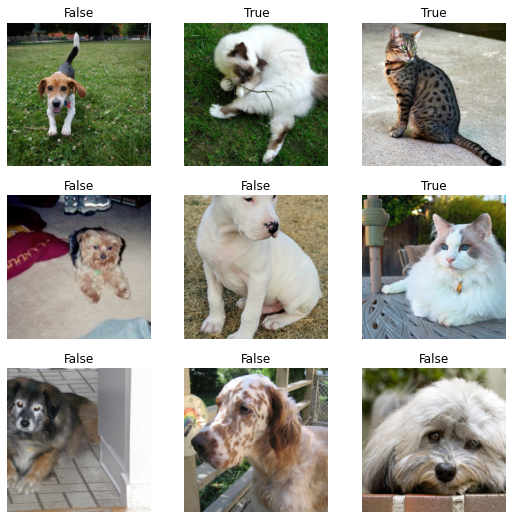

In [ ]:
def label_func(f): 
  name = f.name #on veut accéder aux noms uniquement
  return name[0].isupper()

splitter = RandomSplitter(0.2) #Sépare la base de données entre validation et entrainement

pets = DataBlock(blocks=(ImageBlock, CategoryBlock),  
                 get_items=get_image_files,           
                 get_y = label_func,                  
                 splitter=splitter,
                 item_tfms=[Resize(224)], #resize les images à la taille voulue
                 batch_tfms = Normalize.from_stats(*imagenet_stats))

dls = pets.dataloaders(untar_data(URLs.PETS)/"images", bs=64) #entrée = liste de paths, bs=taille du batch 
dls.show_batch()

Création d'un subset du dataset (afin d'acccélerer l'entrainement)

In [ ]:
dls.train = dls.test_dl(dls.train_ds.items[:1000], with_labels=True)
dls.valid = dls.test_dl(dls.valid_ds.items[:200], with_labels=True)

Le Learner est un objet regroupant le datalaoder dls, l'architecture du réseau ainsi que la métrique pour visualiser ses performances.

In [ ]:
model = resnet34()
learn = Learner(dls=dls,model=model,metrics=accuracy)

In [ ]:
n_epochs = 1 #Nombre de fois où on parcourt l'entièreté du dataset
learn.fit(n_epochs) #Entrainement du réseau sur n_epochs

epoch,train_loss,valid_loss,accuracy,time
0,1.626361,12.796209,0.355000,00:09


Pour info:  La matrice de confusion est un outil qui nous permet d'identifer les classes problèmatiques dans la classification par notre modèle. 

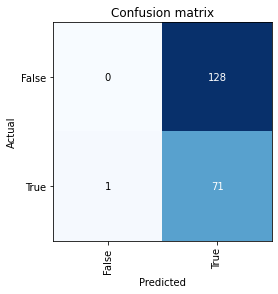

In [ ]:
ci = ClassificationInterpretation.from_learner(learn)
ci.plot_confusion_matrix()

### Exercices :
1. Mettez le nombre d'epochs à 2 et refaites l'entrainement du réseau. Que constatez-vous ? 
2. Modifiez la taille du batch à 128, puis à 2048. Que constatez-vous ? Quelle est l'influence de cette variable ?


## Le préentrainement

Le préentrainement permet d'utiliser les connaissances d'un réseau déjà entraîné sur une base de données plus générales.

Par défaut, les poids du réseau sont initialisés de manière aléatoire. Il nous faut donc forcer le réseau à utiliser les poids pré-entrainés.

In [ ]:
model = resnet34(pretrained=True) #On part des poids préentrainé
learn = Learner(dls=dls,model=model,metrics=accuracy)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
n_epochs = 1
learn.fit(n_epochs) #Fine-tuning

epoch,train_loss,valid_loss,accuracy,time
0,1.509933,17.331846,0.695000,00:09


## Exercices :
Afficher la matrice de confusion de la classification par le modèle préentrainé

In [ ]:
#Votre code ici

Il existe des méthodes d'entraînement relatives au fine-tuning, dont les recherches sur le sujet ont montrées de meilleures performances que les méthodes dites standards. 

Ces méthodes sont implémentées par défaut dans FastAI : 
```
.fit_one_cycle(n_epochs)
```

In [ ]:
model = resnet34(pretrained=True) #On part des poids préentrainé
learn = Learner(dls=dls,model=model,metrics=accuracy)
n_epochs = 1
learn.fit_one_cycle(n_epochs) #Fine-tuning

epoch,train_loss,valid_loss,accuracy,time
0,2.634067,3.601475,0.875000,00:11


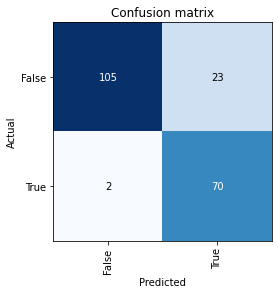

In [ ]:
ci = ClassificationInterpretation.from_learner(learn)
ci.plot_confusion_matrix()

In [ ]:
[f for f in dir(learn) if 'fi' in f] #fit, fine_tune, fit_one_cycle, ...

['_component_attr_filter',
 '_do_fit',
 'final_record',
 'fine_tune',
 'fit',
 'fit_flat_cos',
 'fit_one_cycle',
 'fit_sgdr',
 'lr_find']

Sauvegarder mon modèle

In [ ]:
learn.save('my_model')

Path('models/my_model.pth')

Charger mon modèle

In [ ]:
learn.load('my_model')

# Données Textuelles

Ici, nous allons nous concentrer sur la classification de reviews de film : + ou - ?

In [5]:
from fastai.text.all import *
from fastai.basics import *

Charger la base de données

In [57]:
path = untar_data(URLs.IMDB_SAMPLE)

In [58]:
path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

### Pandas

Pandas est une librairie standard permettant de lire les fichiers .csv. Les fichiers .csv sont des données structurées et organisées sous forme de tableau. Elles peuvent être lues avec Excel.

In [59]:
import pandas as pd

df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [60]:
df['label']

0      negative
1      positive
2      negative
3      positive
4      negative
         ...   
995    negative
996    positive
997    negative
998    negative
999    positive
Name: label, Length: 1000, dtype: object

**Exercice**

Afficher la colonne is_valid

In [61]:
#Votre code ici

In [90]:
dls = TextDataLoaders.from_df(df, path=path, text_col='text', label_col='label', valid_col='is_valid') 
#create a dataloader tuned for text data from pandas DataFrame df

In [119]:
dls.one_batch()[0][0]

TensorText([   2,    8, 2922,  ...,   14,    0,   11])

TensorText([   2,    8, 2922,  ...,   14,    0,   11])

Le texte est une donnée particulière à traiter pour l'ordinateur. Il doit encoder cette modalité de manière à pouvoir traiter l'information.

In [48]:
#@title Création d'un dataset fictif d'exemple
def _prepare_texts(tmp_d):
    "Prepare texts in a folder struct in tmp_d, a csv file and returns a dataframe"
    path = Path(tmp_d)/'tmp'
    path.mkdir()
    for d in ['a', 'b', 'c']: 
        (path/d).mkdir()
        for i in range(5):
            with open(path/d/f'text{i}.txt', 'w') as f: f.write(f"this is an example of text {d} {i}")
    
    texts = [f"this is an example of text {d} {i}" for i in range(5) for d in ['a', 'b', 'c']]
    df = pd.DataFrame({'text': texts, 'label': list(range(15))}, columns=['text', 'label'])
    csv_fname = tmp_d/'input.csv'
    df.to_csv(csv_fname, index=False)
    return path,df,csv_fname

with tempfile.TemporaryDirectory() as tmp_d:
    path,df,csv_fname = _prepare_texts(Path(tmp_d))
    items = get_text_files(path)
    splits = RandomSplitter()(items)
    dsets = Datasets(items, [Tokenizer.from_folder(path)], splits=splits)
    print(dsets.train[0])
    
    dsets = Datasets(df, splits=splits)
    print(dsets.train[0][0].text)

(['xxbos', 'this', 'is', 'an', 'example', 'of', 'text', 'a', '4'],)
this is an example of text a 0


### Tokenizer

In [51]:
print(' ##### Data without Tokenizer #####')
print(dsets.items)
print('##### Data with Tokenizer #####')
tokenized_data=tokenize_df(dsets.items, 0)
print(tokenized_data[0])
print('##### Counter  #####')

print(tokenized_data[1])

 ##### Data without Tokenizer #####
                              text  label
0   this is an example of text a 0      0
1   this is an example of text b 0      1
2   this is an example of text c 0      2
3   this is an example of text a 1      3
4   this is an example of text b 1      4
5   this is an example of text c 1      5
6   this is an example of text a 2      6
7   this is an example of text b 2      7
8   this is an example of text c 2      8
9   this is an example of text a 3      9
10  this is an example of text b 3     10
11  this is an example of text c 3     11
12  this is an example of text a 4     12
13  this is an example of text b 4     13
14  this is an example of text c 4     14
##### Data with Tokenizer #####


    label                                            text  text_length
0       0  [xxbos, this, is, an, example, of, text, a, 0]            9
1       1  [xxbos, this, is, an, example, of, text, b, 0]            9
2       2  [xxbos, this, is, an, example, of, text, c, 0]            9
3       3  [xxbos, this, is, an, example, of, text, a, 1]            9
4       4  [xxbos, this, is, an, example, of, text, b, 1]            9
5       5  [xxbos, this, is, an, example, of, text, c, 1]            9
6       6  [xxbos, this, is, an, example, of, text, a, 2]            9
7       7  [xxbos, this, is, an, example, of, text, b, 2]            9
8       8  [xxbos, this, is, an, example, of, text, c, 2]            9
9       9  [xxbos, this, is, an, example, of, text, a, 3]            9
10     10  [xxbos, this, is, an, example, of, text, b, 3]            9
11     11  [xxbos, this, is, an, example, of, text, c, 3]            9
12     12  [xxbos, this, is, an, example, of, text, a, 4]            9
13    

### Numericalize

In [52]:
num = Numericalize(min_freq=1)

test = [item.split() for i,item in enumerate(dsets.items['text'])]
num.setup(test)

for i in range(len(dsets.items['text'])):
  start = dsets.items['text'][i]
  print('## Before Numericalize ##')
  print(start)
  t = num(start.split())
  print("## After Numericalize ##")
  print(t)

## Before Numericalize ##
this is an example of text a 0
## After Numericalize ##
TensorText([ 9, 10, 11, 12, 13, 14, 15, 18])
## Before Numericalize ##
this is an example of text b 0
## After Numericalize ##
TensorText([ 9, 10, 11, 12, 13, 14, 16, 18])
## Before Numericalize ##
this is an example of text c 0
## After Numericalize ##
TensorText([ 9, 10, 11, 12, 13, 14, 17, 18])
## Before Numericalize ##
this is an example of text a 1
## After Numericalize ##
TensorText([ 9, 10, 11, 12, 13, 14, 15, 19])
## Before Numericalize ##
this is an example of text b 1
## After Numericalize ##
TensorText([ 9, 10, 11, 12, 13, 14, 16, 19])
## Before Numericalize ##
this is an example of text c 1
## After Numericalize ##
TensorText([ 9, 10, 11, 12, 13, 14, 17, 19])
## Before Numericalize ##
this is an example of text a 2
## After Numericalize ##
TensorText([ 9, 10, 11, 12, 13, 14, 15, 20])
## Before Numericalize ##
this is an example of text b 2
## After Numericalize ##
TensorText([ 9, 10, 11, 12, 1

### attrgetter
Récupère le 'text' de la DataFrame


In [53]:
my_attr = attrgetter('text')
my_attr(dsets.items)

0     this is an example of text a 0
1     this is an example of text b 0
2     this is an example of text c 0
3     this is an example of text a 1
4     this is an example of text b 1
5     this is an example of text c 1
6     this is an example of text a 2
7     this is an example of text b 2
8     this is an example of text c 2
9     this is an example of text a 3
10    this is an example of text b 3
11    this is an example of text c 3
12    this is an example of text a 4
13    this is an example of text b 4
14    this is an example of text c 4
Name: text, dtype: object

In [54]:
'''
splits = [L(range(len(df_train))), L(range(len(df_train), len(df_all)))]
tfms = [attrgetter("text"), Tokenizer.from_df(0), Numericalize()]
dsets = Datasets(df_all, [tfms], splits=splits, dl_type=LMDataLoader)
'''

'\nsplits = [L(range(len(df_train))), L(range(len(df_train), len(df_all)))]\ntfms = [attrgetter("text"), Tokenizer.from_df(0), Numericalize()]\ndsets = Datasets(df_all, [tfms], splits=splits, dl_type=LMDataLoader)\n'

### Revenons à notre tâche

In [118]:
learn = text_classifier_learner(dls, AWD_LSTM) 
#l'architecture est AWD_LSTM, un réseau de neurones "State-of-the-Art" dans la modèlisation du langage
#Par défaut, pretrained=True

In [56]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: ignored